Project 4 - Scientific Computing - Kimi Kreilgaard (Twn176)

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

**Le plan**

Step 1: <br>
Vi initializer vores box (-1,41)x(-1,41) med x,y,f(t=0) hvor x,y er et meshgrid der viser position i boxen og f er vores p og q beskrevet i opgaven ved p(x,y,0) og q(x,y,0).

Step 2: <br>
Opdater Ghosts, dvs de rækker og kolloner med -1 eller 41 som skal væres ens med rækker og kolloner i 1 og 39. Det sikrer at laplacen i 0 og 40 sikrer at der ikke er noget udadgående flux fordi elementerne på hver side er det samme, og dermed transporteres der ikke noget ud.

Step 3: <br>
Regn næste time step (hver timestep er et loop men resten kan gøres med array programming) med laplacen der nummerisk regnes som 1D (finite difference approximation p. 454):
$$ \frac{\partial^2p}{\partial x^2}|_{x=L} = \frac{p(L-dx)-2p(L)+p(L+dx)}{(dx)^2} $$
$$ \frac{\partial^2p}{\partial y^2}|_{y=L} = \frac{p(L-dy)-2p(L)+p(L+dy)}{(dy)^2} $$

Then the Laplacian is:
$$ \nabla^2 p = \frac{\partial^2p}{\partial x^2}+\frac{\partial^2p}{\partial y^2} $$
even though he denotes the laplacian as $\Delta$

Step 4: <br>
see picture on how to find dp, which is the formula in the assignment that includes the laplacian. This also goes for q.

Step 5:
find the new p and q with forawrd euler: p(t+dt)=p(t)+dt*dp

Step 6:
repeat stuff

<font color='red'> should there be more than 43x43 elements? more like a linspace ish. This would mean ste_size in the laplacian dx could be smaller than 1. This would mean that we have to change the way we define the initial conditions </font>

# Set up Initial Conditions

In [2]:
# Parameter values
D_p, D_q, C, K = 1, 8, 4.5, 9

In [3]:
# Start by creating the matrices for P and Q
P_with_ghosts = np.zeros((43,43))
Q_with_ghosts = np.zeros((43,43))

#Update with the initial conditions belong to squares 10<x<30 and 10<y<30 in P_inner (11 free on each side)
#In the ghosts matrix there is two more rows and columns thus we use: 11<x<31 and 11<y<31 (12 free on each side)
P_with_ghosts[12:31,12:31] = C + 0.1
Q_with_ghosts[12:31,12:31] = K/C + 0.2

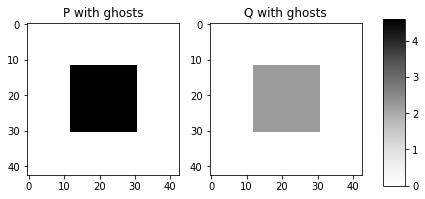

In [4]:
# Display initial conditions
fig, ax = plt.subplots(ncols=2)

mini, maks = np.min((P_with_ghosts, Q_with_ghosts)), np.max((P_with_ghosts, Q_with_ghosts))

im = ax[0].imshow(P_with_ghosts, cmap='Greys', vmin=mini, vmax=maks)
ax[0].set_title('P with ghosts')

ax[1].imshow(Q_with_ghosts, cmap='Greys', vmin=mini, vmax=maks)
ax[1].set_title('Q with ghosts')

cax = plt.axes([0.95, 0.2, 0.05, 0.58])
fig.colorbar(im, cax=cax)
plt.show()

# Create Helper Functions

In [5]:
def update_ghosts(matrix):
    """
    Uses central difference to ensure the no-flux Neunmann boundary conditions. The "ghosts" are an extra border
    around the box which value is set to the same as the value on the other side of the border. This ensures
    that when we use the laplacian on elements near the border (elements with indices containing 1 or 41) which
    is calculated from neighbouring elements, there will be no flux out of the box since fx. elements 0 and 1
    will be the same
    """
    # Make a copy of the matrix so we don't change the original matrix
    matrix = matrix.copy()
    
    # Upper border
    matrix[0,1:-1] = matrix[1, 1:-1]
    
    # Lower border
    matrix[-1,1:-1] = matrix[-2,1:-1]
    
    # Left border
    matrix[1:-1,0] = matrix[1:-1,1]
    
    # Right border
    matrix[1:-1,-1] = matrix[1:-1,-2]
    
    return matrix

In [6]:
def Laplacian(matrix, step_size=1):
    """
    Function that calculates the laplacian for all elements in the matrix except for ghost elements. Assumes
    that the step size in each direction is the same: dx=dy=step_size.
    
    Matrix = matrix with ghosts
    """
    
    # Get submatrices
    inner = matrix[1:-1, 1:-1]
    up = matrix[:-2,1:-1]
    down = matrix[2:,1:-1]
    left = matrix[1:-1,:-2]
    right = matrix[1:-1,2:]
    
    # Laplacian for x
    d2mat_dx2 = (1/step_size**2) * ( left - 2*inner + right )
    
    # Laplacian for y
    d2mat_dy2 = (1/step_size**2) * ( down - 2*inner + up )
    
    # Full laplacian
    Lap = d2mat_dx2 + d2mat_dy2
    
    return Lap

In [7]:
def update_state(P_matrix, Q_matrix, dt, step_size=1, params=(D_p, D_q, C, K)):
    """
    Functions that updates/simulate the state of the reaction diffusion process by one time step dt.
    P_matrix and Q_matrix with ghosts. Returns P_matrix and Q_matrix with (non_updated) ghosts too.
    """
    # Exract parameters
    D_p, D_q, C, K = params[0], params[1], params[2], params[3]
    
    # Get inner matrices
    P_inner = P_matrix[1:-1, 1:-1]
    Q_inner = Q_matrix[1:-1, 1:-1]
    
    # Get Laplacians
    Nabla_P = Laplacian(P_matrix, step_size)
    Nabla_Q = Laplacian(Q_matrix, step_size)
    
    # Get timederivatives
    dP_matrix = D_p * Nabla_P + P_inner**2 * Q_inner + C - (K+1)*P_inner
    dQ_matrix = D_q * Nabla_Q - P_inner**2 * Q_inner + K*P_inner
    
    # Calculate the new matricies P(t+dt)=P(t)+dt*dP/dt and Q(t+dt)=Q(t)+dt*dQ/dt
    P_new = P_inner + dt*dP_matrix
    Q_new = Q_inner + dt*dQ_matrix
    
    # Make matrices size 43x43 again, add ghosts
    P_matrix[1:-1, 1:-1] = P_new
    Q_matrix[1:-1, 1:-1] = Q_new
    
    return P_matrix, Q_matrix

In [8]:
def plotter(P,Q):
    fig, ax = plt.subplots(ncols=2)
    mini, maks = np.min((P, Q)), np.max((P, Q))
    im = ax[0].imshow(P, cmap='Greys', vmin=mini, vmax=maks)
    ax[0].set_title('P with ghosts')
    ax[1].imshow(Q, cmap='Greys', vmin=mini, vmax=maks)
    ax[1].set_title('Q with ghosts')
    cax = plt.axes([0.95, 0.2, 0.05, 0.58])
    fig.colorbar(im, cax=cax)
    plt.show()

# Test it

In [9]:
43-12

31

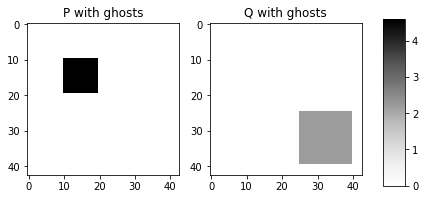

In [10]:
# Parameter values
D_p, D_q, C, K = 1, 8, 4.5, 9

# Start by creating the matrices for P and Q
P_mat = np.zeros((43,43))
Q_mat = np.zeros((43,43))

# Fill out P and Q
P_mat[10:20,10:20] = C + 0.1 
Q_mat[25:40,25:40] = K/C + 0.2

plotter(P_mat,Q_mat)

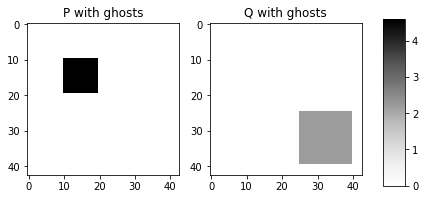

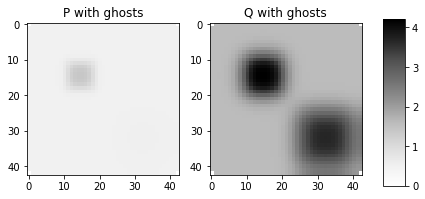

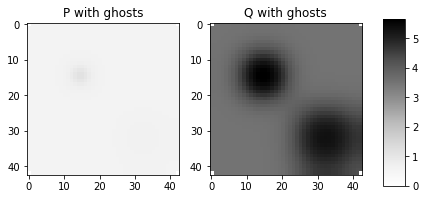

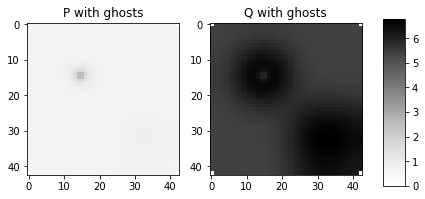

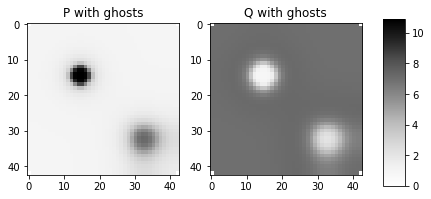

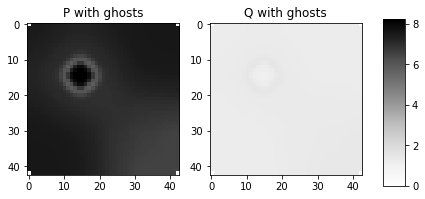

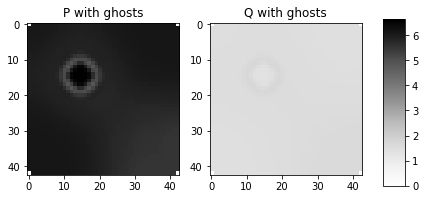

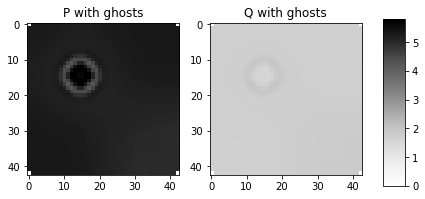

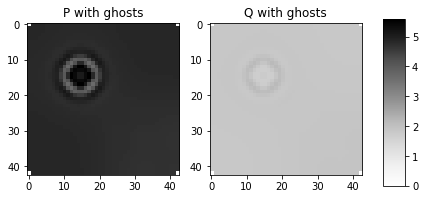

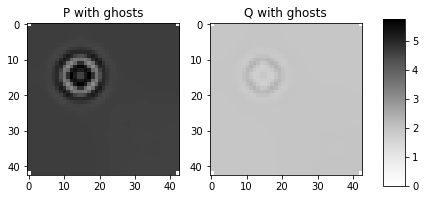

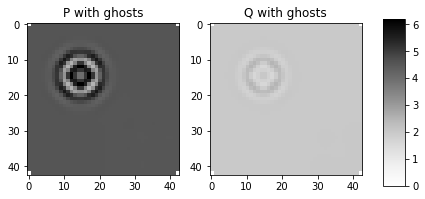

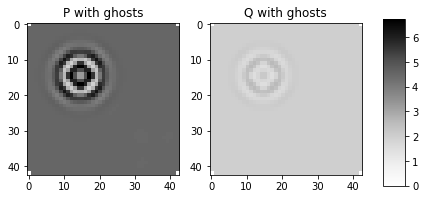

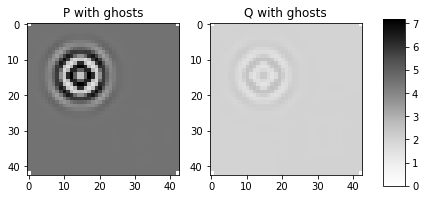

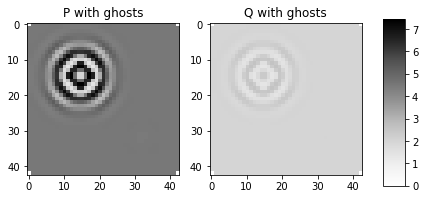

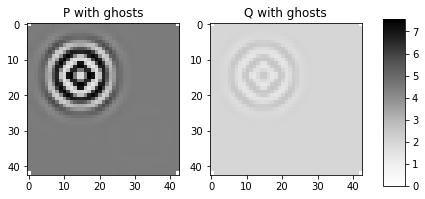

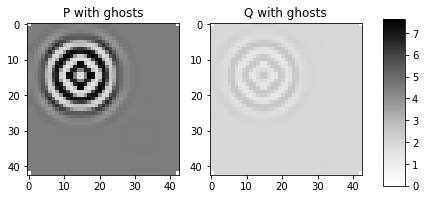

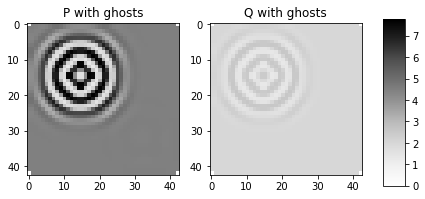

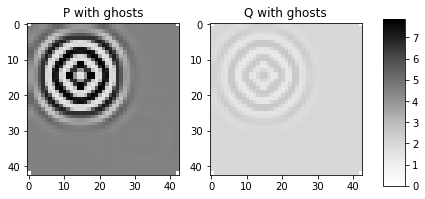

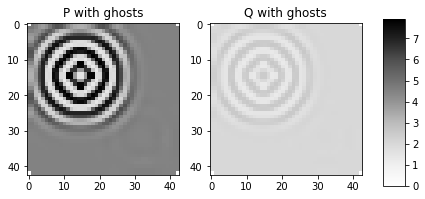

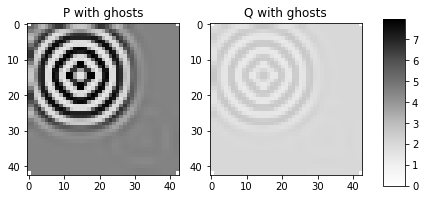

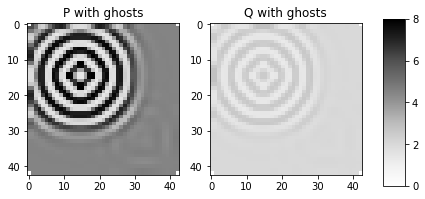

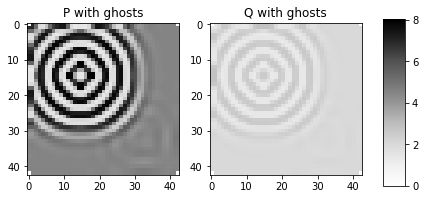

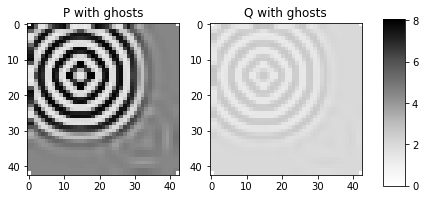

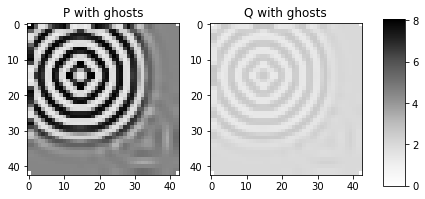

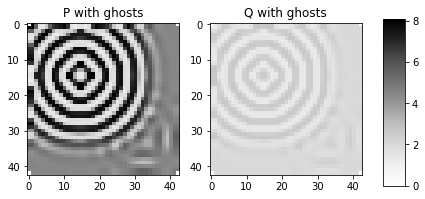

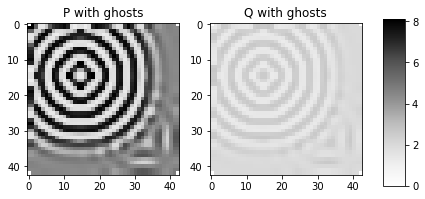

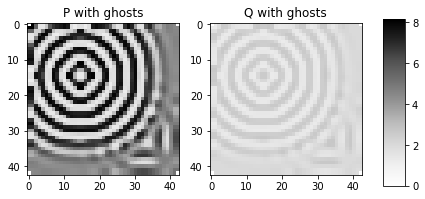

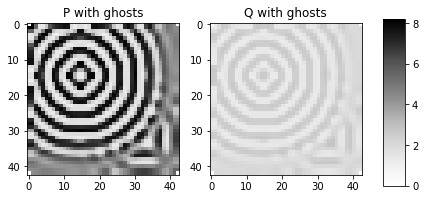

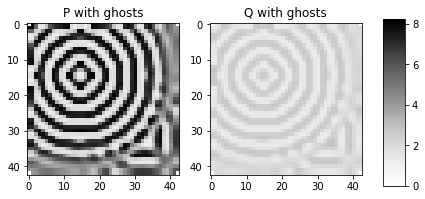

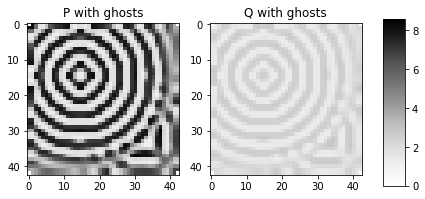

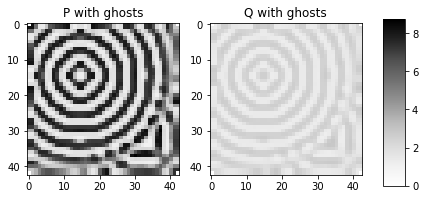

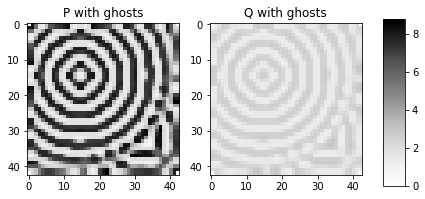

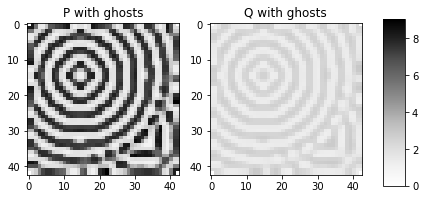

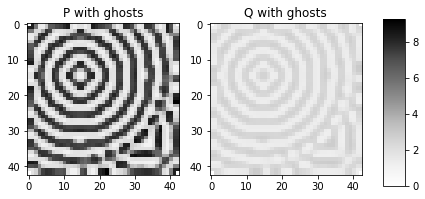

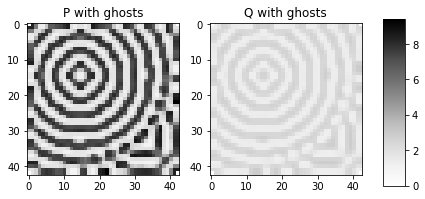

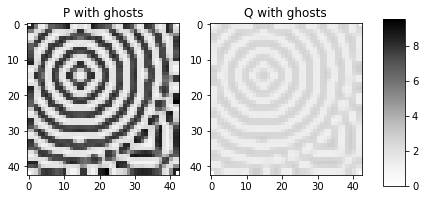

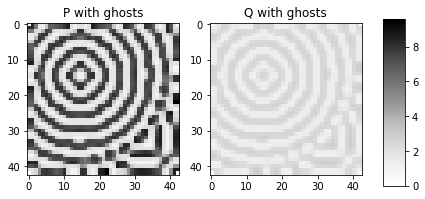

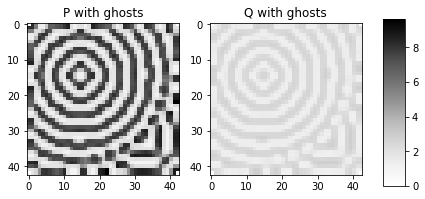

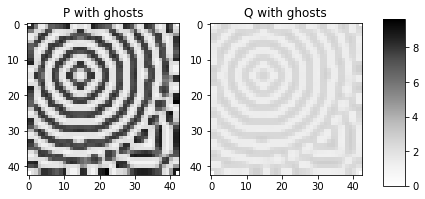

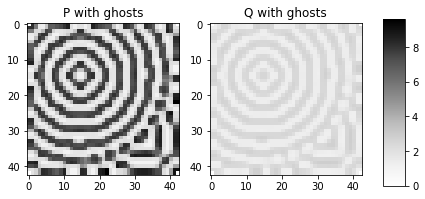

In [11]:
# Parameter values
D_p, D_q, C, K = 1, 8, 4.5, 9

# Start by creating the matrices for P and Q
P_mat = np.zeros((43,43))
Q_mat = np.zeros((43,43))

#Update with the initial conditions belong to squares 10<x<30 and 10<y<30 in P_inner (11 free on each side)
#In the ghosts matrix there is two more rows and columns thus we use: 11<x<31 and 11<y<31 (12 free on each side)

P_mat[10:20,10:20] = C + 0.1 
Q_mat[25:40,25:40] = K/C + 0.2

#P_mat[12:31,12:31] = C + 0.1 
#Q_mat[12:31,12:31] = K/C + 0.2

N=2000 #100000
dt=0.01
for i in range(N):

    # Update ghosts
    P_mat = update_ghosts(P_mat)
    Q_mat = update_ghosts(Q_mat)
    
    # Plot it
    if i in np.arange(0,N,50):
        plotter(P_mat,Q_mat)
    
    # Update state
    P_mat, Q_mat = update_state(P_mat, Q_mat, dt=dt)

In [12]:
1**2/(2*C) #delta t mindre end det jævnfør p. 458

0.1111111111111111

# Different K's

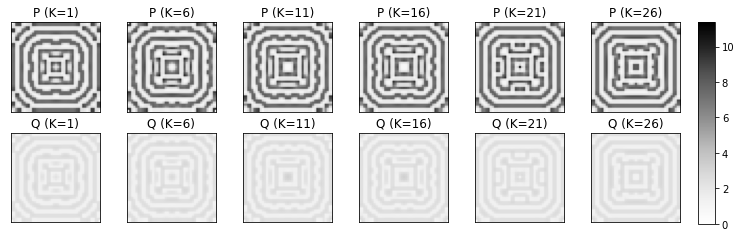

In [17]:
###################################
#  Now we do it with all the K's  #
###################################

# Parameter values
D_p, D_q, C = 1, 8, 4.5
K_arr = np.arange(1,30,5)#np.arange(7,13,1)

# Places to store P and Q matrices
P_list = []
Q_list = []

# Loop over K's
for K in K_arr:

    # Start by creating the matrices for P and Q
    P_mat = np.zeros((43,43))
    Q_mat = np.zeros((43,43))

    #Update with the initial conditions belong to squares 10<x<30 and 10<y<30 in P_inner (11 free on each side)
    #In the ghosts matrix there is two more rows and columns thus we use: 11<x<31 and 11<y<31 (12 free on each side)
    P_mat[12:31,12:31] = C + 0.1 #maybe some other numbers need to draw this out
    Q_mat[12:31,12:31] = K/C + 0.2 #maybe some other numbers need to draw this out

    dt=0.01
    N = 10000 #2000 / dt
    
    for i in range(N):

        # Update ghosts
        P_mat = update_ghosts(P_mat)
        Q_mat = update_ghosts(Q_mat)
    
        # Update state
        P_mat, Q_mat = update_state(P_mat, Q_mat, dt=dt)
        
    # Store the end results
    P_list.append(P_mat)
    Q_list.append(Q_mat)
    
### Plotting it ###

# Set up figure
fig, ax = plt.subplots(nrows=2, ncols=len(K_arr), figsize=(12,4), gridspec_kw={'wspace':0.3, 'hspace':0.03})

# Finding the minimum and maximum value for the collective colorbar
mini, maks = np.min((P_list, Q_list)), np.max((P_list, Q_list))

# Plotting
for i in range(len(K_arr)):
    im = ax[0,i].imshow(P_list[i], cmap='Greys', vmin=mini, vmax=maks)
    ax[0,i].set_title('P (K={})'.format(K_arr[i]))
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    ax[1,i].imshow(Q_list[i], cmap='Greys', vmin=mini, vmax=maks)
    ax[1,i].set_title('Q (K={})'.format(K_arr[i]))
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)

# Add colorbar
cax = plt.axes([0.92, 0.15, 0.02, 0.7]) #[left, bottom, width, height]
fig.colorbar(im, cax=cax)
plt.show()